In [1]:
# referenced https://www.geeksforgeeks.org/recommendation-system-in-python/

# import libraries and prevent warnings from causing messy output
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

In [2]:
# loading datasets
ratings = pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv")

ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
movies = pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Summary Statistics of Ratings

In [4]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [5]:
print("Number of unique movie IDs: " + str(len(ratings['movieId'].unique())))
print("Number of unique users: " + str(len(ratings['userId'].unique())))

Number of unique movie IDs: 9724
Number of unique users: 610


Text(0.5, 1.0, 'Bar Plot of Unique Ratings of first 5 users')

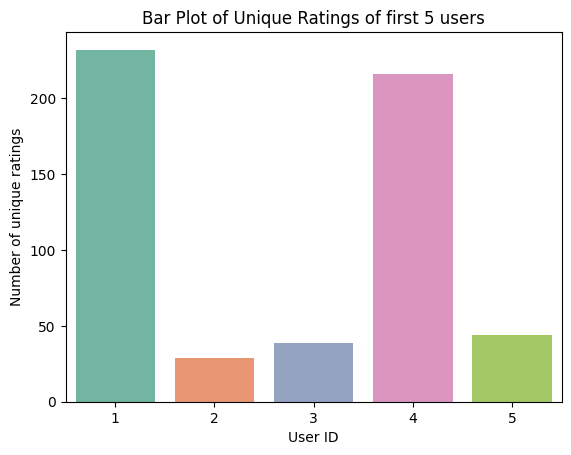

In [6]:
n_ratings = ratings.groupby('userId').size().reset_index(name = 'count')

sns.barplot(x='userId', y='count', data = n_ratings.head(), palette='Set2')

plt.xlabel('User ID')
plt.ylabel('Number of unique ratings')
plt.title('Bar Plot of Unique Ratings of first 5 users')

In [7]:
ratings.groupby('movieId')[['rating']].mean()

ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])


rating          
         count      mean
movieId                 
1          215  3.920930
2          110  3.431818
3           52  3.259615
4            7  2.357143
5           49  3.071429
...        ...       ...
193581       1  4.000000
193583       1  3.500000
193585       1  3.500000
193587       1  3.500000
193609       1  4.000000

[9724 rows x 2 columns]

## Collaborative Filtering

In [9]:
# create user-item matrix using function

from scipy.sparse import csr_matrix

def create_maxtrix(df):
    n_user = len(df['userId'].unique())
    n_movie = len(df['movieId'].unique())

    # mapping ids to indices
    u_map = dict(zip(np.unique(df['userId']), list(range(n_user))))
    m_map = dict(zip(np.unique(df['movieId']), list(range(n_movie))))

    # mapping indices to ids
    u_inv = dict(zip(list(range(n_user)), np.unique(df['userId'])))
    m_inv = dict(zip(list(range(n_movie)), np.unique(df['movieId'])))

    u_index = [u_map[i] for i in df['userId']]
    m_index = [m_map[i] for i in df['movieId']]

    X = csr_matrix((df['rating'], (m_index, u_index)), shape = (n_movie, n_user))

    return X, u_map, m_map, u_inv, m_inv

X, u_map, m_map, u_inv, m_inv = create_maxtrix(ratings)

In [12]:
# function to find similar movies using knn
from sklearn.neighbors import NearestNeighbors

def find_similar(movie, X, k, metric = 'cosine', show_distance = False):
    indice = m_map[movie]
    vector = X[indice].reshape(1,-1)
    k+=1

    model = NearestNeighbors(n_neighbors=k, algorithm='brute',metric=metric)
    model.fit(X)
    
    nn = model.kneighbors(vector, return_distance=show_distance)
    res = [m_inv[nn.item(i)] for i in range(0,k)]
    res.pop(0)

    return res

In [14]:
titles = dict(zip(movies['movieId'], movies['title']))

similar = find_similar(4, X, k=10)
curr = titles[4]

print(f'Since you watched {curr}, you might like: ')
for i in similar:
    print(titles[i])

Since you watched Waiting to Exhale (1995), you might like: 
Before and After (1996)
Walking Dead, The (1995)
Nothing Personal (1995)
Bliss (1997)
Gordy (1995)
Spirits of the Dead (1968)
Sum of Us, The (1994)
I Like It Like That (1994)
Poetic Justice (1993)
Georgia (1995)
